# Vehicle Detection Project

The goal of this project is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Required Libraries 

In [1]:
import glob
import time
import random
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Data Extraction

This project, was provide with a labeled dataset and the job is to decide what features to extract, then train a classifier and ultimately track vehicles in a video stream. Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train the classifier. These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

In [2]:
FOLDER_NAMES ={'non-vehicles':['Extras','GTI'],
               'vehicles':['GTI_FAR','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']}

In [3]:
def extract_images_from_folder(folder):
    cars = []
    notcars = []
    for key in folder.keys():
        if key =="vehicles":
            for folder_name in folder[key]:
                images = glob.glob(key+"/"+folder_name+'/*.png')
                for image in images:
                    cars.append(image)
        else:
            for folder_name in folder[key]:
                for folder_name in folder[key]:
                    images = glob.glob(key+"/"+folder_name+'/*.png')
                    for image in images:
                        notcars.append(image)

    return cars,notcars

In [4]:
cars,notcars = extract_images_from_folder(FOLDER_NAMES)

## Data Exploration

Based on the data exploration, it can be seen that the number of not car examples it approximately 51% more than the number of car examples. This may cause the classifier to have a bias towards not car examples.

In [5]:
print("Number of examples for cars: {}".format(len(cars)))
print("Number of examples for not cars: {}".format(len(notcars)))
car_img = mpimg.imread(cars[0])
notcar_img =mpimg.imread(notcars[0])
print("Shape of cars image {}".format(car_img.shape))
print("Shape of not cars image {}".format(notcar_img.shape))

Number of examples for cars: 8792
Number of examples for not cars: 17936
Shape of cars image (64, 64, 3)
Shape of not cars image (64, 64, 3)


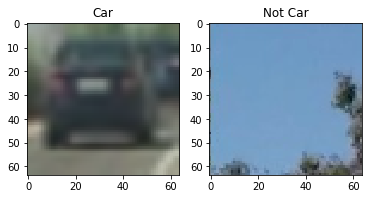

In [6]:
plt.subplot(121)
plt.title("Car")
plt.imshow(car_img)

plt.subplot(122)
plt.title("Not Car")
plt.imshow(notcar_img)
plt.savefig("output_images/car_notcar_example")
plt.show()

In order to prevent the classifier from being bias towards one class over the other 25% of the car examples will be duplicated at random. However, a better approach would be to get new examples of car images, for the classifier to learn from.

In [7]:
def duplicate_data(data,duplication_factor=0.25):
    duplicate_data = []
    randomizer = random.SystemRandom()
    for i in range(int(len(data)*duplication_factor)):
        duplicate_data.append(randomizer.choice(data))
    return np.concatenate((data,duplicate_data))
    
cars = duplicate_data(cars)

In [8]:
print("Number of examples for cars after duplication: {}".format(len(cars)))

Number of examples for cars after duplication: 10990


## Explore Color Spaces for Feature Extraction
In thsi step I try to experiment with different color spaces such as LUV or HLS etc.. to see if I can find a way to consistently separate vehicle images from non-vehicles, so that, it will help when combined with other kinds of features fed into the classifier.

In [9]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if conv == 'BGR2LAB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    

In [10]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


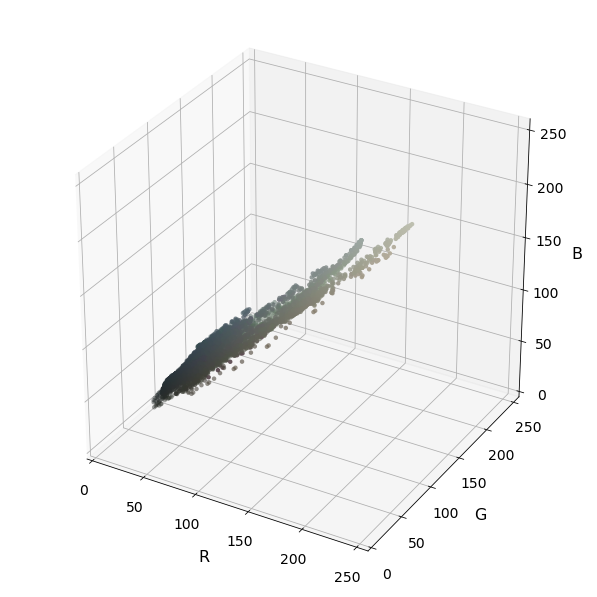

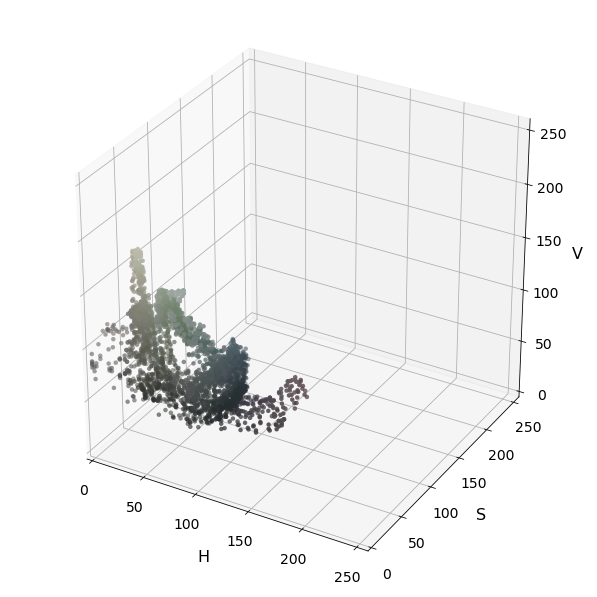

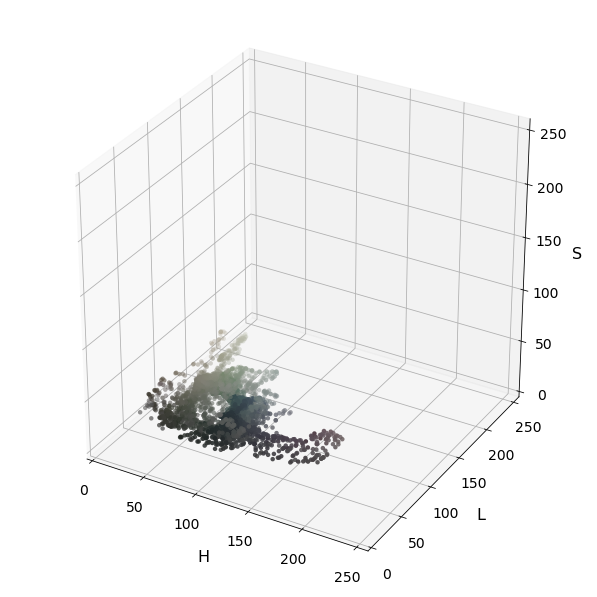

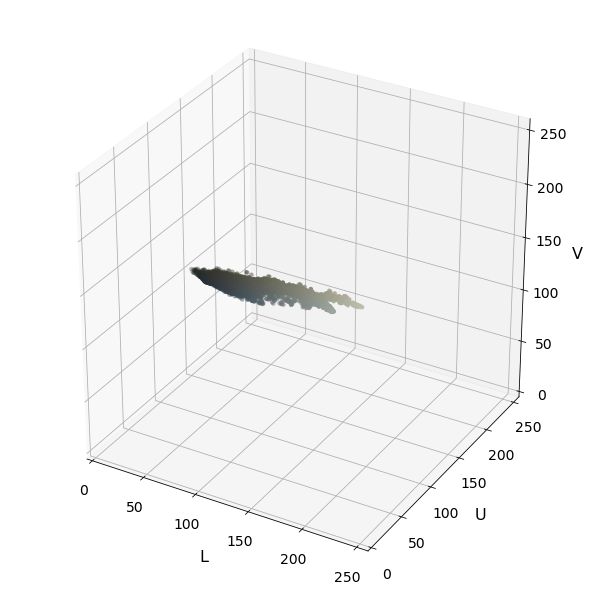

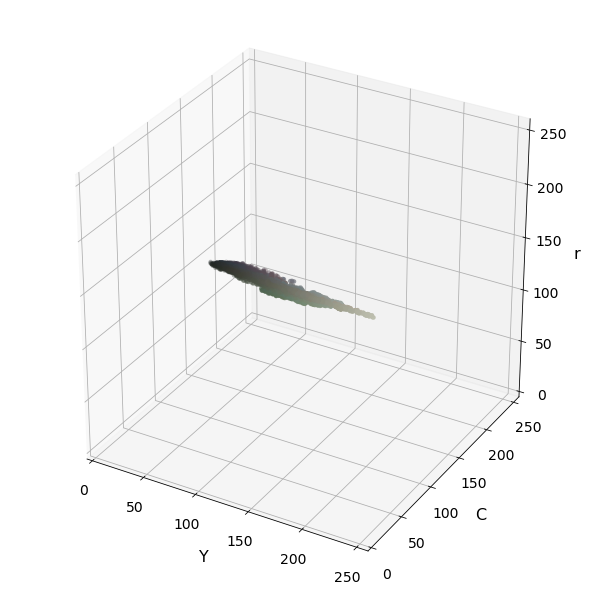

In [63]:
# Read a color image
img = cv2.imread(cars[0])

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = convert_color(img_small, 'BGR2RGB')  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = convert_color(img_small, 'BGR2HSV')
img_small_HLS = convert_color(img_small, 'BGR2HLS')
img_small_LUV = convert_color(img_small, 'BGR2LUV')
img_small_YCrCb = convert_color(img_small, 'BGR2YCrCb')
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show

plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.savefig('output_images/color_space_exploration')
plt.show()

In [12]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [13]:
def bin_spatial(img, conv='RGB2RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if conv != 'RGB2RGB':
        feature_image = convert_color(img, conv)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

### Spatial Binning

Due to it being cumbersome to include three color channels of a full resolution image, therefore I perform spatial binning on an image as it still retains enough information to help in finding vehicles.

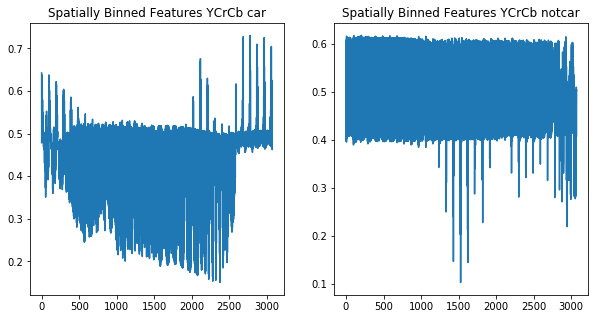

In [14]:
feature_vec_car_ycrcb = bin_spatial(car_img, conv='RGB2YCrCb', size=(32, 32))
feature_vec_notcar_ycrcb = bin_spatial(notcar_img, conv='RGB2YCrCb', size=(32, 32))

# Plot features

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(feature_vec_car_ycrcb)
plt.title('Spatially Binned Features YCrCb car')

plt.subplot(1,2,2)
plt.plot(feature_vec_notcar_ycrcb)
plt.title('Spatially Binned Features YCrCb notcar')
plt.savefig("output_images/spatial_binning_ycrcb")
plt.show()


## HOG (Histogram of Oriented Gradient) Feature Extraction

After a bit of trial and error I found a set of HOG parameters using the function below, which takes a 64x64x3 image and returns a set of features.

As the HOG algorithm is primarily focused on grey images, I initially used the YCrCB colour space with the Y channel (used to represent a gray images). However I disvovered that it was not selective enough during the detection phase. I thus used all 3 colour channels. To reduce the number of features. An orient setting of 9 also showed distinctive features of vehicle. The result is as follows.

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

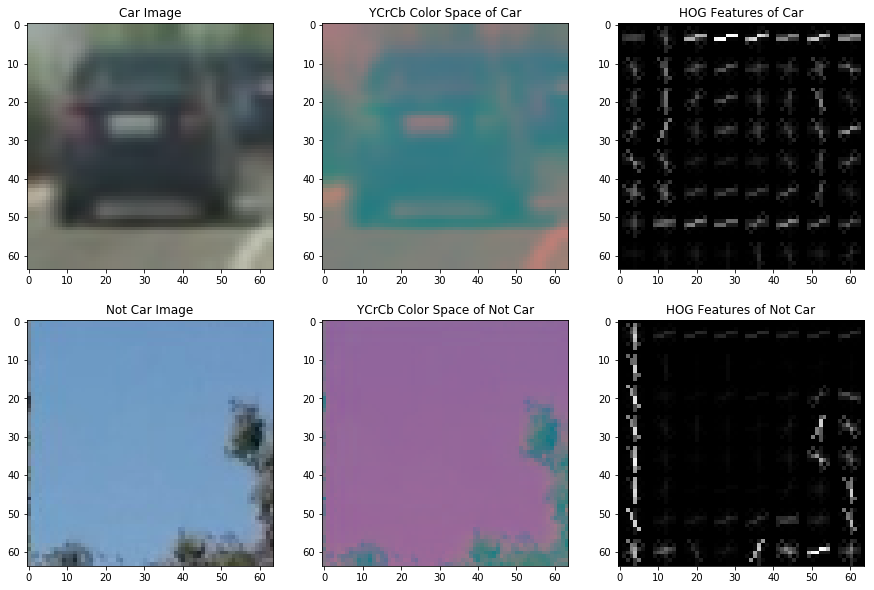

In [16]:
car_img_ycrcb = convert_color(car_img, 'RGB2YCrCb')
car_features,hog_car_img = get_hog_features(car_img_ycrcb[:,:,2],9,8,2,True,True)

notcar_img_ycrcb = convert_color(notcar_img, 'RGB2YCrCb')
notcar_features,hog_notcar_img =get_hog_features(notcar_img_ycrcb[:,:,2],9,8,2,True,True)

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.title('Car Image')
plt.imshow(car_img)

plt.subplot(2,3,2)
plt.title('YCrCb Color Space of Car')
plt.imshow(car_img_ycrcb)

plt.subplot(2,3,3)
plt.title('HOG Features of Car')
plt.imshow(hog_car_img,cmap='gray')


plt.subplot(2,3,4)
plt.title('Not Car Image')
plt.imshow(notcar_img)

plt.subplot(2,3,5)
plt.title('YCrCb Color Space of Not Car')
plt.imshow(notcar_img_ycrcb)

plt.subplot(2,3,6)
plt.title('HOG Features of Not Car')
plt.imshow(hog_notcar_img,cmap='gray')
plt.savefig("output_images/hog_features")
plt.show()


The final parameter settings used was a ```color_space = 'YCrCb'```,```orient = 9```,```pix_per_cell = 8 ```and ```hog_channel = 'ALL'```. 

## Combined Feature Extraction

In [17]:
def extract_features(imgs,
                     cspace='RGB',
                     spatial_size=(32, 32),
                     hist_bins=32,
                     hist_range=(0, 256),
                     orient=9,
                     pix_per_cell=8,
                     cell_per_block=2,
                     hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

The ```extract_features``` function helps extract HOG features Colour Hist and Bin Spatial features from car (GTI Vehicle Image Database and Extras) and not_car (GTI, KITTI) image sets. In the next step they were then stacked and converted to float.The features were then normaized using the Sklearn StandardScaler as normalizing ensures that a classifier's behavior isn't dominated by just a subset of the features, and that the training process is as efficient as possible.The result are as follows.

In [18]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 18    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
hist_range =(0,256)

In [19]:
t=time.time()

car_features = extract_features(cars, cspace=color_space,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, cspace=color_space,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

189.64 Seconds to extract HOG features...


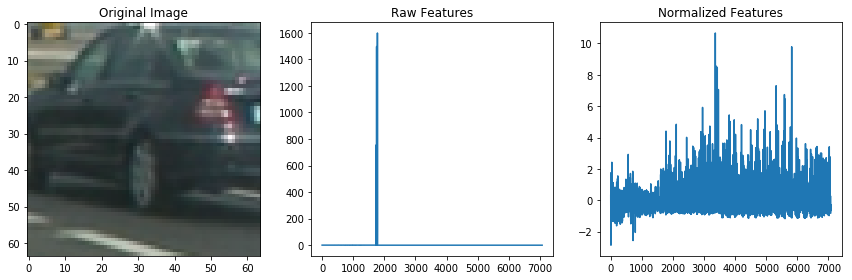

In [20]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig("output_images/raw_normalized_features")
plt.show()
y = np.hstack((np.ones(len(car_features)),
                np.zeros(len(notcar_features))))

## Training a Classifier

### Split the Data
The first step in training the classifier, I first split the data into a ```training set``` (80%) and a ```test set``` (20%). 

In [21]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=rand_state)

### Model Selection

This section involves, Identifying the best the classfier that is able to distinguish a vehicle from what is not a vehicle.

The list of models that are verified are as follows:
- Linear SVC (SVC)
- Random Forest Classifier (RF)

In [22]:
models = []
models.append(('SVC',LinearSVC()))
models.append(('RF',RandomForestClassifier()))

In [23]:
results = []
names =[]
for name,model in models:
    #10-fold Cross Validation
    kfold = KFold(n_splits=10,random_state=rand_state)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "Model Name: %s | Mean Accuracy: %f | SD: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model Name: SVC | Mean Accuracy: 0.995765 | SD: (0.001090)
Model Name: RF | Mean Accuracy: 0.988980 | SD: (0.002075)


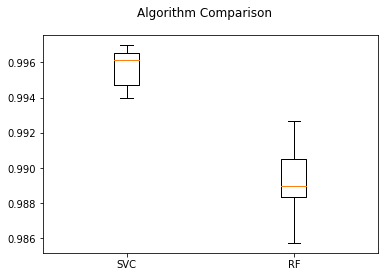

In [27]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('output_images/classifier_comparison')
plt.show()

From the above graph it can be clearly seen that SVC has a better performance than the Random Forest Classifier.

### Optimize Model Parameters

In a SVM I am searching for two things, a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. The problem is that one has to sacraficed for the other. The C parameter determines how great the desire is for the latter. Since a low value for C helps the model geaneralize better, I therefore want to identify the most optimal value for C, which would help prevent the model from overfitting.

In [26]:
tuned_parameters = [{'C':[10**x for x in range(-3,3,1)]}]
svc_opt = GridSearchCV(LinearSVC(),tuned_parameters,cv=kfold,scoring="accuracy")
svc_opt.fit(X_train,y_train)
print("Best Params for SVC: " + str(svc_opt.best_params_))
optimized_predictions = svc_opt.predict(X_test)

#saving the model
pickle.dump(svc_opt,open("model.pkl","wb"))

print("Accuracy: " + str(accuracy_score(y_test,optimized_predictions)))

print("Confusion Matrix: ")
print(confusion_matrix(y_test,optimized_predictions))
print(classification_report(y_test,optimized_predictions))


Best Params for SVC: {'C': 0.001}
Accuracy: 0.995506394746
Confusion Matrix: 
[[3605    4]
 [  22 2155]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00      3609
        1.0       1.00      0.99      0.99      2177

avg / total       1.00      1.00      1.00      5786



Based on the results, the optimal value for the C parameter is `0.001`.

## Slide Window Search

The sliding window algoritm implemented takes in an image ```img```, start and stop positions in both x and y ```x_start_stop```,```y_start_stop``` i.e. (a bounding box for the entire search region), window size ```xy_window``` (x and y dimensions), and overlap fraction ```xy_overlap``` (also for both x and y). This function returns a list of bounding boxes for the search windows, which is then passed to draw ```draw_boxes()``` function.

The window size and overlap were selected over several trials. The size of the window was also compared to the size of an expected car in the image.


In [28]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if y_start_stop[0] == None:
        y_start_stop[0]=0
    if x_start_stop[1] ==None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1]==None:
        y_start_stop[1]= img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [29]:
def multi_scale_window_search(image,show_img=False):


    windows_scale_0 = slide_window(image, x_start_stop=[250, 1100], y_start_stop=[400, 450],
                        xy_window=(48, 48), xy_overlap=(0.5, 0.5))

    window_0_img = draw_boxes(image, windows_scale_0, color=(0, 0, 255), thick=6)


    windows_scale_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600],
                        xy_window=(115, 115), xy_overlap=(0.7, 0.6))

    window_1_img = draw_boxes(image, windows_scale_1, color=(0, 0, 255), thick=6)


    windows_scale_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650],
                        xy_window=(128, 128), xy_overlap=(0.7, 0.6))

    window_2_img = draw_boxes(image, windows_scale_2, color=(0, 0, 255), thick=6)


    windows_scale_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600],
                        xy_window=(80, 80), xy_overlap=(0.8, 0.7))

    window_3_img = draw_boxes(image, windows_scale_3, color=(0, 0, 255), thick=6)


    windows_scale_4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600],
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    window_4_img = draw_boxes(image, windows_scale_4, color=(0, 0, 255), thick=6)

    if show_img:
        fig = plt.figure(figsize=(20,35))

        plt.subplot(511)
        plt.imshow(window_0_img)

        plt.subplot(512)
        plt.imshow(window_1_img)

        plt.subplot(513)
        plt.imshow(window_2_img)

        plt.subplot(514)
        plt.imshow(window_3_img)

        plt.subplot(515)
        plt.imshow(window_4_img)
        plt.savefig('output_images/multiscale_window_search')
        plt.show()
    windows = np.concatenate((windows_scale_0,
                              windows_scale_1,
                              windows_scale_2,
                              windows_scale_3,
                              windows_scale_4))
    return windows

In [30]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Windows of different scales

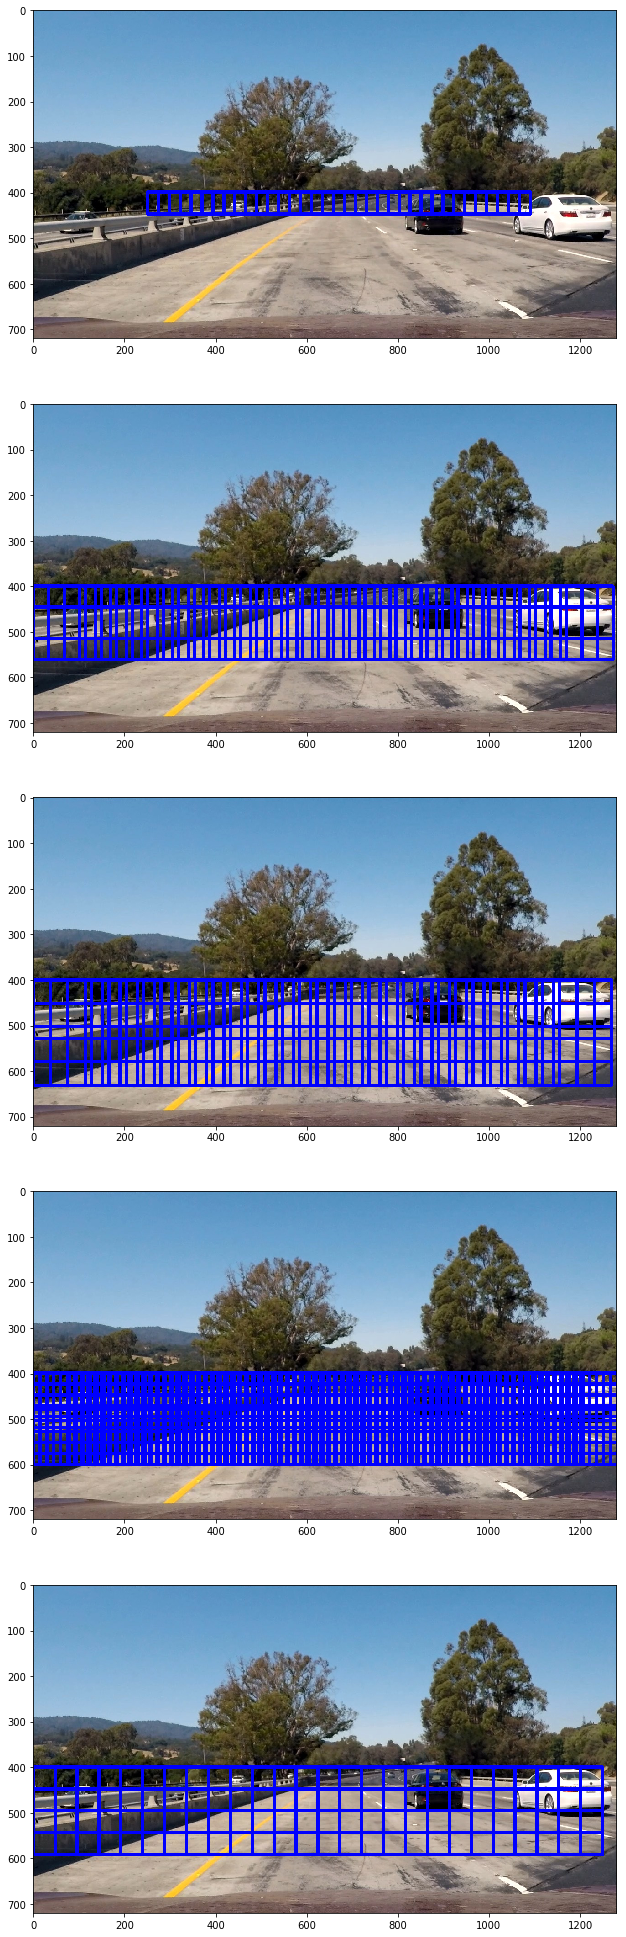

In [31]:
image = mpimg.imread('test_images/test1.jpg')
windows = multi_scale_window_search(image,show_img=True)

## Search and Classify
This step involves combining both the sliding window search on an image and the trained classifier, to be able to correctly identify the cars in the image.

A efficient method for doing the sliding window approach, is to only extract the Hog features once. The function ```find_cars``` is able to both extract features and make predictions.

The function ```find_cars``` only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's ```8 x 8 ``` cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%.

This function can be run multiple times for different scale values to generate multiple-scaled search windows.

In [32]:
def find_cars(img, 
              ystart, 
              ystop,
              xstart,
              xstop,
              scale,
              step,
              svc, 
              X_scaler, 
              orient, 
              pix_per_cell, 
              cell_per_block, 
              spatial_size, 
              hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bbox_list = []

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list


In [50]:
def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))


def draw_labeled_bboxes(labels):
    THRES_LEN = 32
    Y_MIN = 440
    ALPHA = 0.75 # Filter parameter, weight of the previous measurements
    global track_list
    track_list_l = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #img = draw_boxes(np.copy(img), [bbox], color=(255,0,255), thick=3)
        size_x = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y = (bbox[1][1]-bbox[0][1])/2.0
        asp_d = size_x / size_y
        size_m = (size_x + size_y)/2
        x = size_x+bbox[0][0]
        y = size_y+bbox[0][1]
        asp = (y-Y_MIN)/130.0+1.2 # Best rectangle aspect ratio for the box (coefficients from perspectieve measurements and experiments)
        if x>1050 or x<230:
            asp*=1.4
        asp = max(asp, asp_d) # for several cars chunk
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        if x > (-3.049*y+1809): #If the rectangle on the road, coordinates estimated from a test image
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d = min(dist)
                if min_d < THRES_LEN:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], ALPHA)
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        #print(track_to_box(track))
        boxes.append(track_to_box(track))
   
    return boxes


## Handeling Multiple Detections & False Positives
In order to reduce number of false positives a heatmap with a threshold approach was implemented using the function ```add_heat()```.

In [35]:
def add_heat(heatmap,bbox_list,threshold):
    """
    This function iterartes through the list of bounding boxes
    and adds 1 for all pixels within each bounding box.

    Assuming that each "box" takes the form ((x1,y1),(x2,y2))
    """
    for bbox in bbox_list:
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    #Add zeros to the pixels that are below the threshold
    heatmap[heatmap <= threshold]=0
    return heatmap

### Load the Model

In [36]:
model = pickle.load(open('model.pkl', 'rb'))

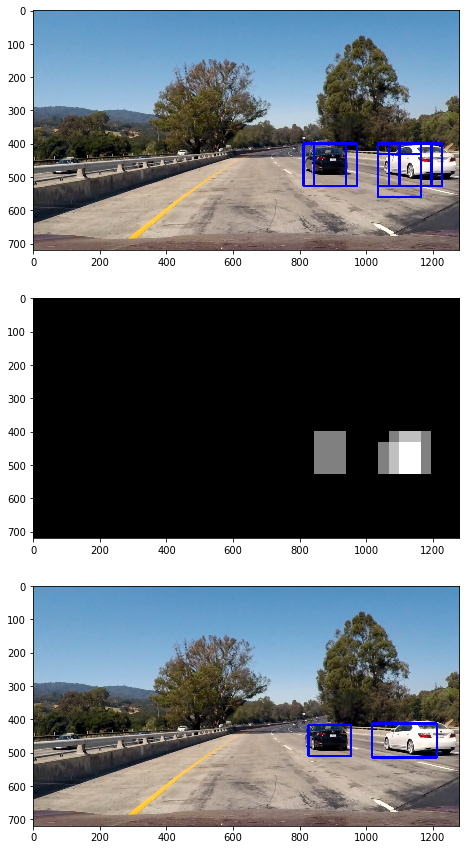

In [51]:
img = mpimg.imread('test_images/test1.jpg')
ystart = 400
ystop = 656
xstart = 650
xstop = 1280
scale = 2.0
step = 2

bbox_list = find_cars(img, ystart, ystop, xstart, xstop ,scale,step, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
fig = plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.imshow(draw_boxes(img,bbox_list))

heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bbox_list,threshold=1)
plt.subplot(3,1,2)
plt.imshow(heatmap,cmap='gray')

labels = label(heatmap)
boxs = draw_labeled_bboxes(labels)
out_img = draw_boxes(img, boxs, color=(0, 0, 255), thick=6)
plt.subplot(3,1,3)
plt.imshow(out_img)
plt.savefig('output_images/window_search_heatmap_car_detect')
plt.show()

## Pipeline Implementation Ideas

1. In the first step the images were preprocessed by undistortion process from the Advanced Lane Line finding project.
2. The same steps from the Advanced Lane Lines Findig project was used in the pipeline, in order to detect the lane lines.
3. To reduce number of false positives a heatmap with a threshold approach was also implemented. For video the heatmap is accumulated by value given for ```num_frames```. This in turn reduces number of outliers false positives.
4. In order to improve performance it requires to analize the smallest possible number of windows. That is why, scanning across the entire image was a bad idea and a better approach is to only scan areas where a new car can appear and also scan areas where a car was detected.
5. I used different scale of the classifiers window on different parts of the image due to perspective. So, different ROI window sizes were applied on different areas.

### Import Helper functions from Lane Line Detector

In [47]:
from lanelines_detector_helper import *

In [53]:
class Line:
    def __init__(self):
        # Was the lineprevious frame found found in the 
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image,search):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if search == "Right":
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

class EnvironmentDetector():
    
    def __init__(self,model=None,
                      X_scaler=None,
                      pix_per_cell=None,
                      orient=None,
                      cell_per_block=None,
                      spatial_size=None,
                      hist_bins=None,
                      threshold =1,
                      num_frames=2):
        self.calibration_folder = CAMERA_CALIBRATION_IMAGES_FOLDER
        self.objpoints,self.imgpoints = calibrate_camera(self.calibration_folder,show_image=False)
        self.Left = Line()
        self.Right = Line()
        self.ystarts = [400,400,400,400,400,400]
        self.ystops = [650,500,650,500,460,650]
        self.xstarts = [950,950,0,0,330,650]
        self.xstops = [1280,1280,330,330,950,1280]
        self.scales =  [2.0,1.5,2.0,1.5,0.75,1.0]
        self.steps = [2,2,2,2,3,2]
        self.model =  model
        self.X_scaler = X_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.num_frames= num_frames
        self.threshold = threshold
        self.bbox_list = []
        self.heatmap = None
        self.labels=None
        self.ncount = 0
        self.car_boxes = None
        self.prev_frame_boxes =None
        self.THRES_LEN = 32
        self.Y_MIN = 440
        self.ALPHA = 0.75
        
    def pipeline(self,image,display_steps=False):
        steps = []
        img_size = (image.shape[1], image.shape[0])
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(self.objpoints,
                                                       self.imgpoints,
                                                       img_size,
                                                       None,
                                                       None)
        undist = undistort_image(image,mtx,dist)
        if display_steps:
            steps.append(np.copy(undist))
        
        warped,Minv  =  perspective_transform(undist,img_size)
        if display_steps:
            steps.append(np.copy(warped))
            
        combined_binary = combine_thresh(warped)
        if display_steps:
            steps.append(np.copy(combined_binary))
        
        
        # Identify all non zero pixels in the image
        x, y = np.nonzero(np.transpose(combined_binary)) 

        if self.Left.found == True: # Search for left lane pixels around previous polynomial
            leftx, lefty, self.Left.found = self.Left.found_search(x, y)

        if self.Right.found == True: # Search for right lane pixels around previous polynomial
            rightx, righty, self.Right.found = self.Right.found_search(x, y)


        if self.Right.found == False: # Perform blind search for right lane lines
            rightx, righty, self.Right.found = self.Right.blind_search(x, y, combined_binary,"Right")

        if self.Left.found == False:# Perform blind search for left lane lines
            leftx, lefty, self.Left.found = self.Left.blind_search(x, y, combined_binary,"Left")

        lefty = np.array(lefty).astype(np.float32)
        leftx = np.array(leftx).astype(np.float32)
        righty = np.array(righty).astype(np.float32)
        rightx = np.array(rightx).astype(np.float32)

        # Calculate left polynomial fit based on detected pixels
        left_fit = np.polyfit(lefty, leftx, 2)

        # Calculate intercepts to extend the polynomial to the top and bottom of warped image
        leftx_int, left_top = self.Left.get_intercepts(left_fit)

        # Average intercepts across n frames
        self.Left.x_int.append(leftx_int)
        self.Left.top.append(left_top)
        leftx_int = np.mean(self.Left.x_int)
        left_top = np.mean(self.Left.top)
        self.Left.lastx_int = leftx_int
        self.Left.last_top = left_top

        # Add averaged intercepts to current x and y vals
        leftx = np.append(leftx, leftx_int)
        lefty = np.append(lefty, 720)
        leftx = np.append(leftx, left_top)
        lefty = np.append(lefty, 0)

        # Sort detected pixels based on the yvals
        leftx, lefty = self.Left.sort_vals(leftx, lefty)

        self.Left.X = leftx
        self.Left.Y = lefty

        # Recalculate polynomial with intercepts and average across n frames
        left_fit = np.polyfit(lefty, leftx, 2)
        self.Left.fit0.append(left_fit[0])
        self.Left.fit1.append(left_fit[1])
        self.Left.fit2.append(left_fit[2])
        left_fit = [np.mean(self.Left.fit0), 
                    np.mean(self.Left.fit1), 
                    np.mean(self.Left.fit2)]

        # Fit polynomial to detected pixels
        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
        self.Left.fitx = left_fitx

        # Calculate right polynomial fit based on detected pixels
        right_fit = np.polyfit(righty, rightx, 2)

        # Calculate intercepts to extend the polynomial to the top and bottom of warped image
        rightx_int, right_top = self.Right.get_intercepts(right_fit)

        # Average intercepts across 5 frames
        self.Right.x_int.append(rightx_int)
        rightx_int = np.mean(self.Right.x_int)
        self.Right.top.append(right_top)
        right_top = np.mean(self.Right.top)
        self.Right.lastx_int = rightx_int
        self.Right.last_top = right_top
        rightx = np.append(rightx, rightx_int)
        righty = np.append(righty, 720)
        rightx = np.append(rightx, right_top)
        righty = np.append(righty, 0)

        # Sort right lane pixels
        rightx, righty = self.Right.sort_vals(rightx, righty)
        self.Right.X = rightx
        self.Right.Y = righty

        # Recalculate polynomial with intercepts and average across n frames
        right_fit = np.polyfit(righty, rightx, 2)
        self.Right.fit0.append(right_fit[0])
        self.Right.fit1.append(right_fit[1])
        self.Right.fit2.append(right_fit[2])
        right_fit = [np.mean(self.Right.fit0), np.mean(self.Right.fit1), np.mean(self.Right.fit2)]

        # Fit polynomial to detected pixels
        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
        self.Right.fitx = right_fitx

        # Compute radius of curvature for each lane in meters
        left_curverad,right_curverad,curvature = measure_curvature(left_fit,right_fit,leftx,rightx,lefty,righty)
        # Only print the radius of curvature every 3 frames for improved readability
        if self.Left.count % 3 == 0:
            self.Left.radius = left_curverad
            self.Right.radius = right_curverad

        self.Left.count += 1

        #Find the distance from the center
        center= center_of_vehicle(left_fit,right_fit)
        
        #Draw the lane lines
        output_img = draw(image,combined_binary,undist,Minv,left_fit,right_fit,center,curvature)
        
        if display_steps:
            left_fit,right_fit,leftx,rightx,lefty,righty,find_lane_line_img = window_slide_fit_line_hist(combined_binary,9,False,left_fit,right_fit,True)
            steps.append(find_lane_line_img)
        
        
        #Multiscale Window search
        for ystart,ystop,xstart,xstop,scale,step in zip(self.ystarts,
                                                        self.ystops,
                                                        self.xstarts,
                                                        self.xstops,
                                                        self.scales,
                                                        self.steps):
            self.bbox_list += find_cars(undist, 
                                  ystart, 
                                  ystop,
                                  xstart,
                                  xstop, 
                                  scale,
                                  step, 
                                  self.model, 
                                  self.X_scaler, 
                                  self.orient, 
                                  self.pix_per_cell, 
                                  self.cell_per_block, 
                                  self.spatial_size, 
                                  self.hist_bins)
        
        for track in track_list:
            y_loc = track[1]+track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0
            if lane_w < 96:
                lane_w = 96
            lane_h = lane_w/1.2
            lane_w = max(lane_w, track[2])
            xs = track[0]-lane_w
            xf = track[0]+lane_w
            if track[1] < self.Y_MIN:
                track[1] = self.Y_MIN
            ys = track[1]-lane_h
            yf = track[1]+lane_h
            if xs < 0: xs=0
            if xf > 1280: xf=1280
            if ys < self.Y_MIN - 40: ys=self.Y_MIN - 40
            if yf > 720: yf=720
            size_sq = lane_w / (0.015*lane_w+0.3)
            scale = size_sq / 64.0
            self.bbox_list+=find_cars(undist, 
                                  int(ys), 
                                  int(yf),
                                  int(xs),
                                  int(xf), 
                                  scale,
                                  2, 
                                  self.model, 
                                  self.X_scaler, 
                                  self.orient, 
                                  self.pix_per_cell, 
                                  self.cell_per_block, 
                                  self.spatial_size, 
                                  self.hist_bins)
            self.bbox_list+=find_cars(undist, 
                                  int(ys), 
                                  int(yf),
                                  int(xs),
                                  int(xf), 
                                  scale*1.25,
                                  2, 
                                  self.model, 
                                  self.X_scaler, 
                                  self.orient, 
                                  self.pix_per_cell, 
                                  self.cell_per_block, 
                                  self.spatial_size, 
                                  self.hist_bins)
            self.bbox_list+=find_cars(undist, 
                                  int(ys), 
                                  int(yf),
                                  int(xs),
                                  int(xf), 
                                  scale*1.5,
                                  2, 
                                  self.model, 
                                  self.X_scaler, 
                                  self.orient, 
                                  self.pix_per_cell, 
                                  self.cell_per_block, 
                                  self.spatial_size, 
                                  self.hist_bins)
            self.bbox_list+=find_cars(undist, 
                                  int(ys), 
                                  int(yf),
                                  int(xs),
                                  int(xf), 
                                  scale*1.75,
                                  2, 
                                  self.model, 
                                  self.X_scaler, 
                                  self.orient, 
                                  self.pix_per_cell, 
                                  self.cell_per_block, 
                                  self.spatial_size, 
                                  self.hist_bins)
                  
        
        if not self.ncount % self.num_frames:
            
            if display_steps:
                steps.append(draw_boxes(np.copy(output_img), self.bbox_list, color=(0, 0, 255), thick=6) )
                
            self.heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
            self.heatmap = add_heat(self.heatmap,self.bbox_list,threshold=self.threshold)
            
            if display_steps:
                steps.append(self.heatmap)
                
            self.labels = label(self.heatmap)
            self.car_boxes = draw_labeled_bboxes(self.labels)
            self.prev_frame_boxes = self.car_boxes
            self.bbox_list = []
        else:
           self.car_boxes = self.prev_frame_boxes 
        
        output_img = draw_boxes(np.copy(output_img), self.car_boxes, color=(0, 0, 255), thick=6) 
            
        self.ncount += 1
        
        if display_steps:
            steps.append(np.copy(output_img))
            return steps
        
        return output_img
     

### Visualize Pipeline

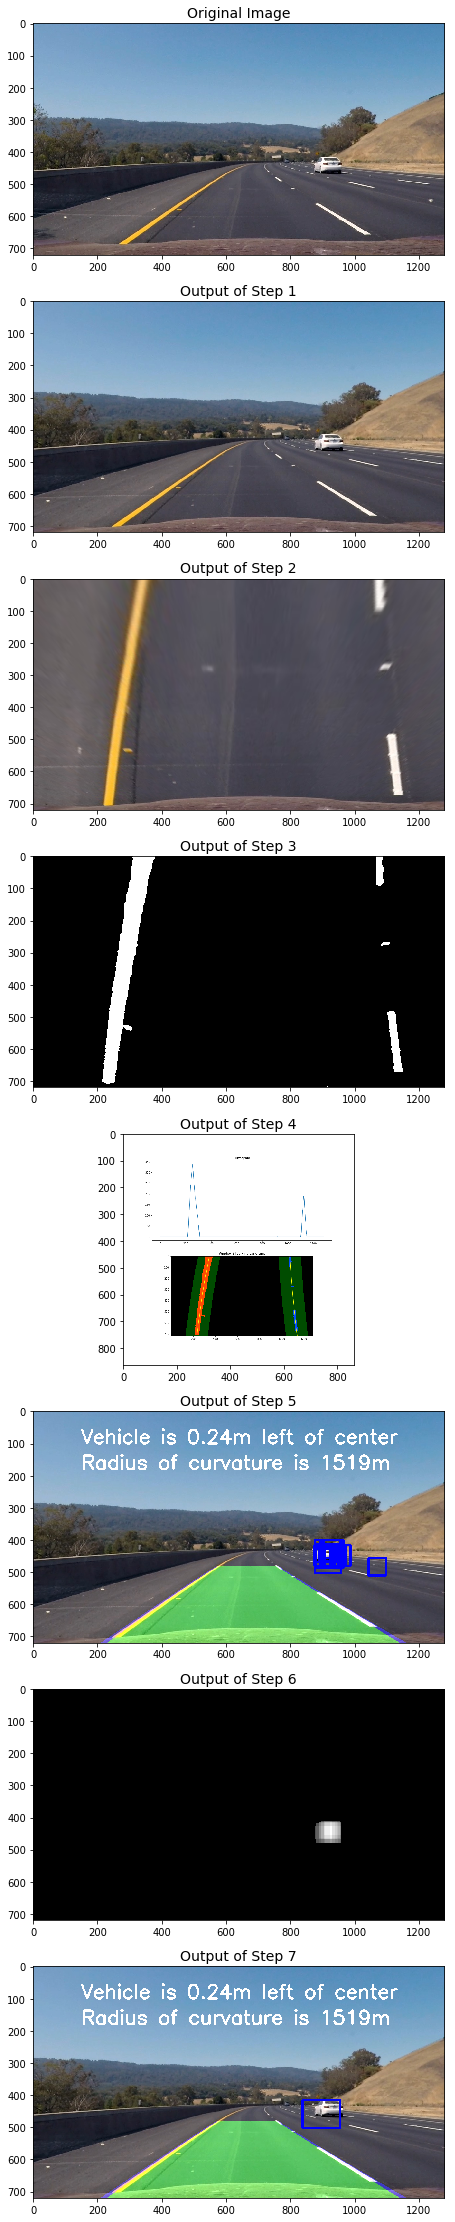

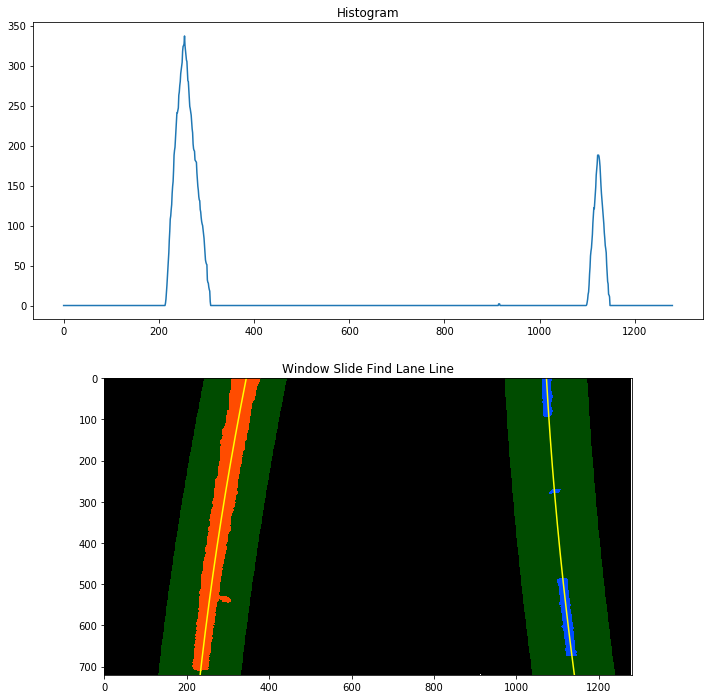

In [54]:
ed = EnvironmentDetector(model=model,
                                   X_scaler=X_scaler,
                                   pix_per_cell=pix_per_cell,
                                   orient=orient,
                                   cell_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   threshold=4,
                                   num_frames=2)
fig=plt.figure(figsize=(15, 40))
img = mpimg.imread('test_images/test3.jpg')
num_of_imgs = 1
returned_imgs = ed.pipeline(img,True)
steps = len(returned_imgs) + 1
count = 1

x = fig.add_subplot(steps,num_of_imgs,count)
x.set_title('Original Image',size=14)
x.imshow(img)
count +=1

for ret_img in returned_imgs:
    z = fig.add_subplot(steps,num_of_imgs,count)
    z.set_title('Output of Step {}'.format(count-1),size=14)
    if count  == 3 or count == 4 or count == 7:
        z.imshow(ret_img,cmap='gray')
    else:
        z.imshow(ret_img)
    count+=1

fig.savefig("output_images/pipeline_step_by_step")  
plt.show()

## Video Processing

In [55]:
def process_video(video_input,video_output):
    """
    This function help process the video through the pipeline frame by frame  and
    finally saves the the output video to a specified file.
    """
    detector = EnvironmentDetector(model=model,
                                   X_scaler=X_scaler,
                                   pix_per_cell=pix_per_cell,
                                   orient=orient,
                                   cell_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   threshold =4,
                                   num_frames=2)
    clip = VideoFileClip(video_input)
    processed = clip.fl_image(detector.pipeline)
    %time processed.write_videofile(video_output, audio=False)

### Test Video

In [56]:
TEST_VID_INPUT = "test_videos/test_video.mp4"
TEST_VID_OUTPUT = "test_videos_output/test_video.mp4"
process_video(TEST_VID_INPUT,TEST_VID_OUTPUT)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|█████████▋| 38/39 [01:05<00:01,  1.79s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 1min 6s, sys: 2.54 s, total: 1min 9s
Wall time: 1min 6s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(TEST_VID_OUTPUT))

### Project Video

In [58]:
PROJ_VID_INPUT = "test_videos/project_video.mp4"
PROJ_VID_OUTPUT = "test_videos_output/project_video.mp4"
process_video(PROJ_VID_INPUT,PROJ_VID_OUTPUT)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [32:47<00:01,  1.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 33min 55s, sys: 1min 7s, total: 35min 2s
Wall time: 32min 48s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(PROJ_VID_OUTPUT))

### Challenge Video

In [60]:
CHALLENGE_VID_INPUT = "test_videos/challenge_video.mp4"
CHALLENGE_VID_OUTPUT = "test_videos_output/challenge_video.mp4"
process_video(CHALLENGE_VID_INPUT,CHALLENGE_VID_OUTPUT)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [11:51<00:00,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 12min 20s, sys: 23.3 s, total: 12min 43s
Wall time: 11min 52s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(CHALLENGE_VID_OUTPUT))

## Conclusion

The pipeline implemented is able to correctly identify the cars in the video frames. However, there are still a few false positive detected in the video frame and the implemented pipeline may also fail in case of difficult light conditions. These problems can be overcome by collecting more data (i.e. images of vehicles and non-vehicles) in different conditions and re-training the model. It is also possible to improve the classifier by additional data augmentation, hard negative mining, classifier parameters tuning etc.

Other models such as Convolutional Neural Networks, can also be used to learn the discriminative features between a vehicle and a non-vehicle. This may improve both the accuracy of vehicle detection and maybe more efficient.

The vehicle detection algorithm also has problems in the scenario where a car overlaps one another. Resolving this problem would require introducing a long term memory of car position and using a predictive algorithm to predict where the car can be and estimate the region to search for the car.

Another improvement would be to eliminate false positives on areas out of the road. This would require combining results from the Advanced Lane Line finding project to correctly determine the region of interest on the whole frame by the road boundaries.

The pipeline is not efficient to process the frame in real-time. In order to achieve this, it would require optimizing the number of features and feature extraction parameters as well as number of analyzed windows to increase the rate the rate of detection. Parallel processing (i.e. having to concurrent pipelines) finding both the lane lines and the vehicles on the street, would be a better solution, as compared to the current one.  